In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 100)

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from tqdm.auto import tqdm
from sklearn.cluster import KMeans

from selenium import webdriver
import folium
from geopy.distance import geodesic
from scipy.spatial.distance import cdist
from colors import colors

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
df = pd.read_csv('cian_short.csv', low_memory=False, index_col='cid')
df.drop(['living_space_unit', 'location_direction', 'location_distance'], axis=1, inplace=True)
print(df.shape)
df.head(3)

(56704, 18)


,location_sub_locality_name,location_address,location_latitude,location_longitude,metro_name,metro_time_on_foot,sales_agent_category,price_value,area_value,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,metro_time_on_transport,price_agent_fee,studio
cid,,,,,,,,,,,,,,,,,,
10712873,ЦАО,"улица Гашека, 11",55.769707,37.591117,Маяковская; Белорусская; Тверская,6; 10; 13,agency,100000.0,45.0,27.0,8.0,"ID 105 Сдается от 1 мес!Отчетные документы, ре...",2.0,4.0,5.0,NaN,NaN,NaN
12833884,ЦАО,"улица Остоженка, 25",55.739554,37.597414,Кропоткинская; Парк Культуры,7; 7,agency,500000.0,150.0,100.0,50.0,Агенту Бонус 50/50 ЖК Опера Хаус. В аренду пр...,3.0,2.0,7.0,NaN,NaN,NaN
145766778,ЦАО,"улица Шаболовка, 23к4",55.722162,37.613090,Шаболовская,8,agency,140000.0,114.0,64.0,20.0,"ЖК Созвездие капитал-1, Предлагается в аренду ...",3.0,3.0,20.0,NaN,NaN,NaN


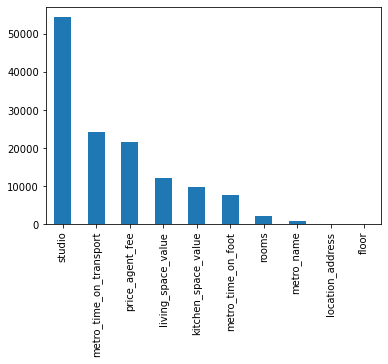

In [3]:
df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False).plot(kind='bar')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56704 entries, 10712873 to 9761071
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   location_sub_locality_name  56704 non-null  object 
 1   location_address            56636 non-null  object 
 2   location_latitude           56704 non-null  float64
 3   location_longitude          56704 non-null  float64
 4   metro_name                  55933 non-null  object 
 5   metro_time_on_foot          49010 non-null  object 
 6   sales_agent_category        56704 non-null  object 
 7   price_value                 56704 non-null  float64
 8   area_value                  56704 non-null  float64
 9   living_space_value          44463 non-null  float64
 10  kitchen_space_value         46908 non-null  float64
 11  description                 56704 non-null  object 
 12  rooms                       54413 non-null  float64
 13  floor                 

In [5]:
sub_locality_names = sorted(df['location_sub_locality_name'].unique())
sub_locality_colors = np.random.choice(range(len(colors)), len(sub_locality_names))

In [6]:
# my_map = folium.Map(
#     location=df[['location_latitude', 'location_longitude']].mean().tolist(), 
#     zoom_start = 10,
#     disable_3d=True
# )

# for ind, row in tqdm(df.iterrows()):
#     lat = row['location_latitude']
#     lon = row['location_longitude']
#     color_ind = sub_locality_names.index(row['location_sub_locality_name'])
#     color = colors[sub_locality_colors[color_ind]].hex_format()
#     folium.Circle(location=[lat, lon],
#                   radius=4, fill=True, color=color
#                  ).add_to(my_map)
    
# my_map.save('map.html')

In [7]:
df[['metro_name', 'metro_time_on_foot', 'metro_time_on_transport']].tail()

,metro_name,metro_time_on_foot,metro_time_on_transport
cid,,,
274061445,Академическая,11,NaN
274064448,Водный стадион; Балтийская; Войковская,7; 15,5
274065318,Солнцево,2,NaN
274068212,Саларьево; Румянцево; Солнцево,NaN,3; 6; 6
9761071,Маяковская; Белорусская; Баррикадная,10; 14; 17,NaN


In [8]:
df[['metro_1', 'metro_2', 'metro_3']] = df['metro_name'].str.split(';', expand=True)
df[['metro_1_foot', 'metro_2_foot', 'metro_3_foot']
  ] = df['metro_time_on_foot'].str.split(';', expand=True).astype(np.float32)
df[['metro_1_transport', 'metro_2_transport', 'metro_3_transport']
  ] = df['metro_time_on_transport'].str.split(';', expand=True).astype(np.float32)
df = df.drop(['metro_name', 'metro_time_on_foot', 'metro_time_on_transport'], axis=1)

In [9]:
df['metro_foot_max'] = df[['metro_1_foot', 'metro_2_foot', 'metro_3_foot']].fillna(-1).max(axis=1)
df['metro_foot_min'] = df[['metro_1_foot', 'metro_2_foot', 'metro_3_foot']].fillna(999).min(axis=1)

df['metro_transport_max'] = df[['metro_1_transport', 'metro_2_transport', 'metro_3_transport']
                              ].fillna(-1).max(axis=1)
df['metro_transport_min'] = df[['metro_1_transport', 'metro_2_transport', 'metro_3_transport']
                              ].fillna(999).min(axis=1)
df[[i for i in df.columns if 'metro' in i]]

,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min
cid,,,,,,,,,,,,,
10712873,Маяковская,Белорусская,Тверская,6.0,10.0,13.0,NaN,NaN,NaN,13.0,6.0,-1.0,999.0
12833884,Кропоткинская,Парк Культуры,None,7.0,7.0,NaN,NaN,NaN,NaN,7.0,7.0,-1.0,999.0
145766778,Шаболовская,None,None,8.0,NaN,NaN,NaN,NaN,NaN,8.0,8.0,-1.0,999.0
148813955,Окская,None,None,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,-1.0,999.0
148978886,Сокол,Красный Балтиец,Аэропорт,7.0,7.0,18.0,NaN,NaN,NaN,18.0,7.0,-1.0,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
274061445,Академическая,None,None,11.0,NaN,NaN,NaN,NaN,NaN,11.0,11.0,-1.0,999.0
274064448,Водный стадион,Балтийская,Войковская,7.0,15.0,NaN,5.0,NaN,NaN,15.0,7.0,5.0,5.0
274065318,Солнцево,None,None,2.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,-1.0,999.0


In [10]:
df[['metro_1', 'metro_2', 'metro_3']] = df[['metro_1', 'metro_2', 'metro_3']].fillna('none')
df[['metro_1_foot', 'metro_2_foot', 'metro_3_foot']
  ] = df[['metro_1_foot', 'metro_2_foot', 'metro_3_foot']].fillna(-1)
df[['metro_1_transport', 'metro_2_transport', 'metro_3_transport']
  ] = df[['metro_1_transport', 'metro_2_transport', 'metro_3_transport']].fillna(-1)

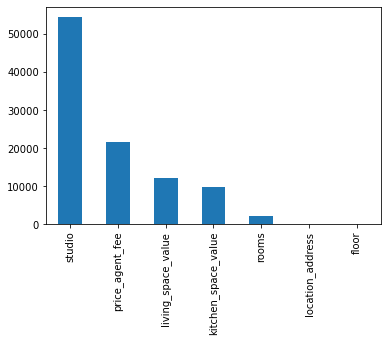

In [11]:
df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False).plot(kind='bar')
plt.show()

In [12]:
df['price_agent_fee'] = df['price_agent_fee'].fillna(0).astype(np.uint8)
df['studio'] = df['studio'].fillna(0).astype(np.uint8)

In [13]:
rooms_mapping = {
    271104489: 2,
    271587353: 0,
    269991656: 0,
    272082709: 3
}
def fill_rooms(x, missing=0):
    return rooms_mapping.get(x.name, missing)

In [14]:
df['rooms'] = df[['rooms']].apply(fill_rooms, axis=1)

In [18]:
df['rooms'].isnull().sum()

0

In [23]:
df[['price_agent_fee', 'studio', 'rooms']].isnull().sum()

price_agent_fee    0
studio             0
rooms              0
dtype: int64

In [15]:
df[df['floor'].isnull()]

,location_sub_locality_name,location_address,location_latitude,location_longitude,sales_agent_category,price_value,area_value,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
272459217,ЦАО,"набережная Пресненская, 8с1",55.747115,37.539078,agency,700000.0,235.0,NaN,NaN,Лот 36882. Предлагаются прекрасные апартамент...,0,NaN,73.0,0,0,Международная,Выставочная,Деловой центр,4.0,-1.0,-1.0,1.0,2.0,-1.0,4.0,4.0,2.0,1.0
266256803,ЦАО,"улица Остоженка, 7С1",55.742767,37.600792,agency,400000.0,220.0,NaN,NaN,Кристина. КОЛЛЕГАМ БОНУС 50%. БЕЗ КОМИССИИ ДЛЯ...,0,NaN,7.0,0,0,Кропоткинская,none,none,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,5.0,-1.0,999.0


In [16]:
def fill_floor(row):
    return df[df['location_address'] == row['location_address']]['floor'].median()

In [17]:
res = df[df['floor'].isnull()].apply(fill_floor, axis=1)

In [18]:
df.loc[res.index, 'floor'] = res.values

In [19]:
df_agg = df.groupby('location_address').agg({'floors_total':'max'})

In [20]:
def floors_total_adjust(row):
    if type(row['location_address']) == float:
        return row['floors_total']
    else:
        return df_agg.loc[row['location_address']]['floors_total']

In [21]:
df['floors_total_adjust'] = df.apply(floors_total_adjust, axis=1)

In [22]:
df['living_space_share'] = df['living_space_value'] / df['area_value']
df['kitchen_space_share'] = df['kitchen_space_value'] / df['area_value']

In [23]:
df_agg = df.groupby(['location_sub_locality_name'])[['kitchen_space_share', 'living_space_share']].median()
df_agg

,kitchen_space_share,living_space_share
location_sub_locality_name,,
ВАО,0.181818,0.583333
ЗАО,0.175439,0.586207
НАО (Новомосковский),0.232558,0.520000
САО,0.178571,0.593750
СВАО,0.190476,0.576271
СЗАО,0.181818,0.583333
ЦАО,0.149254,0.622222
ЮАО,0.189189,0.571429
ЮВАО,0.195122,0.571429


In [24]:
def fill_kitchen_space_shares(row):
    if np.isnan(row['kitchen_space_share']):
        return df_agg.loc[row['location_sub_locality_name']]['kitchen_space_share']
    else:
        return row['kitchen_space_share']
    
def fill_living_space_shares(row):
    if np.isnan(row['living_space_share']):
        return df_agg.loc[row['location_sub_locality_name']]['living_space_share']
    else:
        return row['living_space_share']

In [25]:
df['kitchen_space_share'] = df.apply(fill_kitchen_space_shares, axis=1)

In [26]:
df['living_space_share'] = df.apply(fill_living_space_shares, axis=1)

In [27]:
df['kitchen_space_value'] = df['kitchen_space_share'] * df['area_value']
df['living_space_value'] = df['living_space_share'] * df['area_value']

In [28]:
df[['kitchen_space_share', 'area_value', 'kitchen_space_value']]

,kitchen_space_share,area_value,kitchen_space_value
cid,,,
10712873,0.177778,45.0,8.000000
12833884,0.333333,150.0,50.000000
145766778,0.175439,114.0,20.000000
148813955,0.285714,35.0,10.000000
148978886,0.119760,167.0,20.000000
...,...,...,...
274061445,0.120482,83.0,10.000000
274064448,0.170732,41.0,7.000000
274065318,0.100000,100.0,10.000000


In [29]:
df.drop('location_address', axis=1, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56704 entries, 10712873 to 9761071
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   location_sub_locality_name  56704 non-null  object 
 1   location_latitude           56704 non-null  float64
 2   location_longitude          56704 non-null  float64
 3   sales_agent_category        56704 non-null  object 
 4   price_value                 56704 non-null  float64
 5   area_value                  56704 non-null  float64
 6   living_space_value          56704 non-null  float64
 7   kitchen_space_value         56704 non-null  float64
 8   description                 56704 non-null  object 
 9   rooms                       56704 non-null  int64  
 10  floor                       56704 non-null  float64
 11  floors_total                56704 non-null  float64
 12  price_agent_fee             56704 non-null  uint8  
 13  studio                

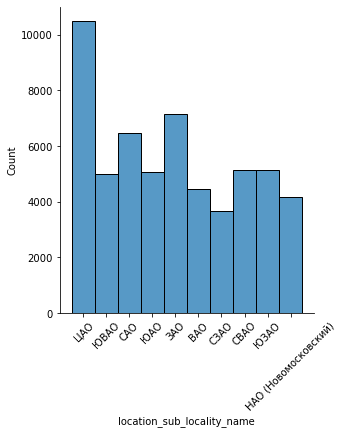

In [31]:
sns.displot(data=df, x='location_sub_locality_name', kind='hist')
plt.xticks(rotation=45)
plt.show()

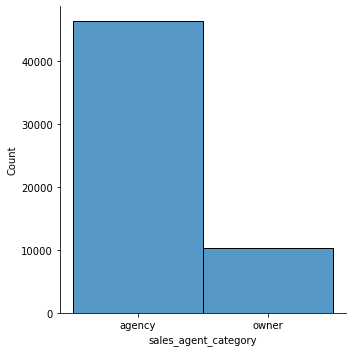

In [32]:
sns.displot(data=df, x='sales_agent_category', kind='hist')
plt.show()

In [69]:
tmp = df.groupby('sales_agent_category', as_index=False).agg({'price_value': 'count'})
# tmp['sales_agent_category'] = tmp['sales_agent_category'].map({'agency': 'агенство', 'owner': 'владелец'})
tmp.columns = ['Категория продавца', 'Кол-во объявлений']
# tmp.set_index('Категория продавца').hist()

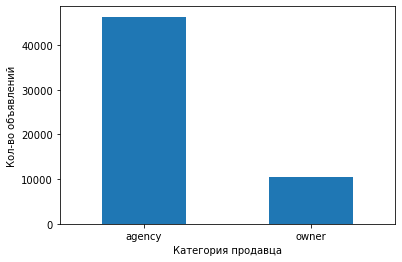

In [70]:
tmp.set_index('Категория продавца').plot(kind='bar', legend=None)
plt.xticks(rotation=0)
plt.ylabel('Кол-во объявлений')
plt.legend = ''
plt.show()

In [33]:
df['price_per_sqm'] = df['price_value'] / df['area_value']

In [34]:
num_cols = [k for i, k in zip(df.dtypes, df.columns)  if i != 'O']

In [35]:
cat_cols = ['location_sub_locality_name', 'sales_agent_category', 'metro_1', 'metro_2', 'metro_3']

In [36]:
df = df[(df['price_per_sqm']<20000) & (df['price_per_sqm'] > 250)]

In [37]:
df.sort_values('price_value')[['location_sub_locality_name', 
                               'price_value', 'area_value', 'price_per_sqm']]

,location_sub_locality_name,price_value,area_value,price_per_sqm
cid,,,,
271133148,НАО (Новомосковский),15000.0,46.0,326.086957
273144306,ЮЗАО,15000.0,22.0,681.818182
271144118,НАО (Новомосковский),16000.0,20.0,800.000000
272693412,НАО (Новомосковский),18000.0,38.0,473.684211
271954706,НАО (Новомосковский),18000.0,60.0,300.000000
...,...,...,...,...
272419391,ЦАО,3000000.0,358.0,8379.888268
268953362,ЦАО,3000000.0,358.0,8379.888268
268954105,ЦАО,3000000.0,358.0,8379.888268


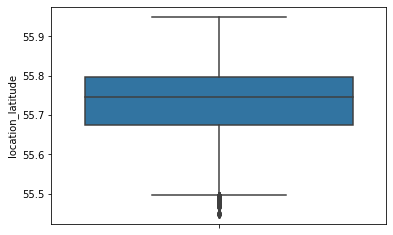

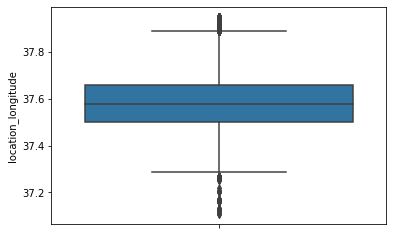

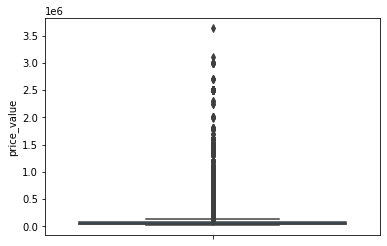

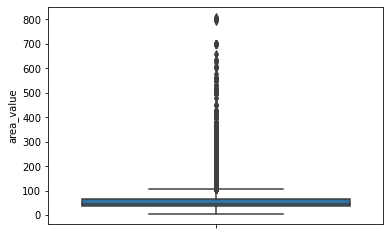

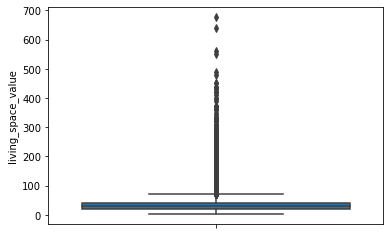

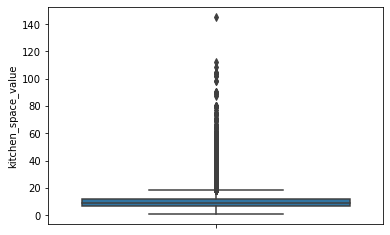

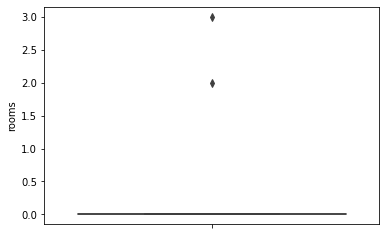

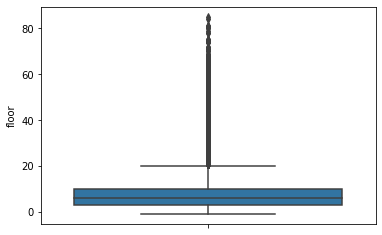

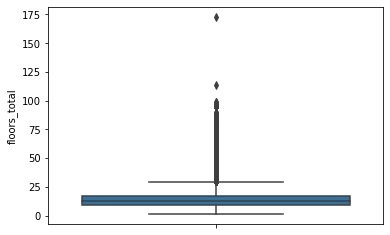

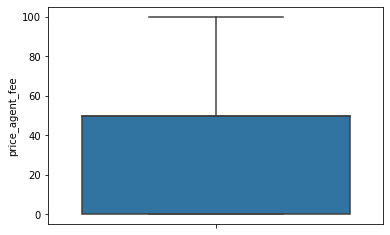

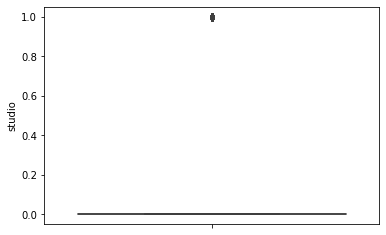

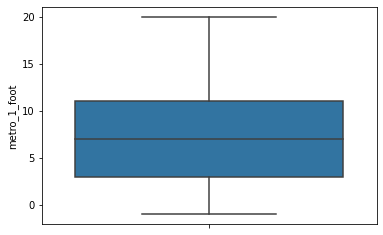

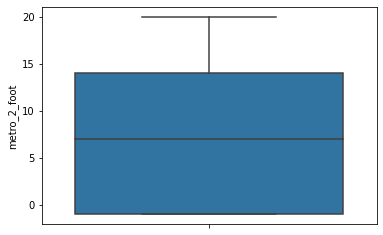

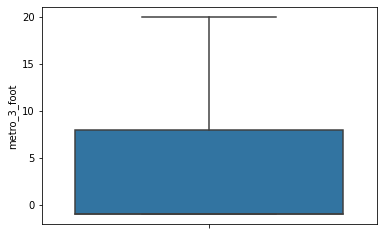

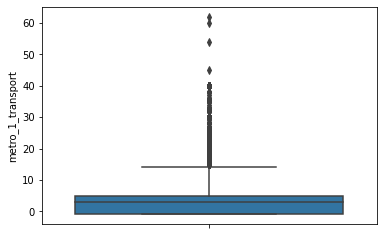

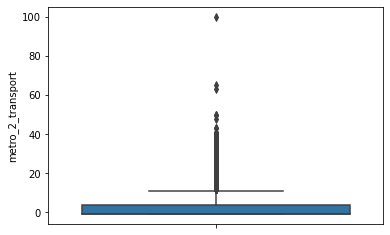

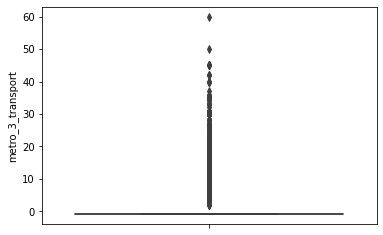

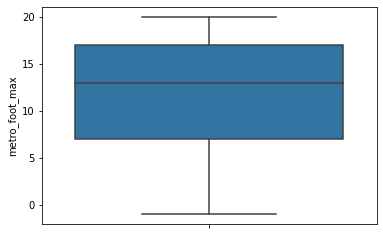

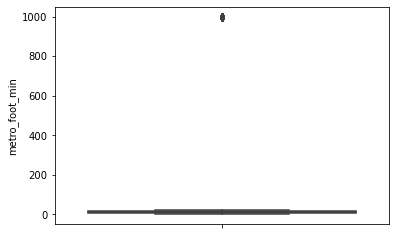

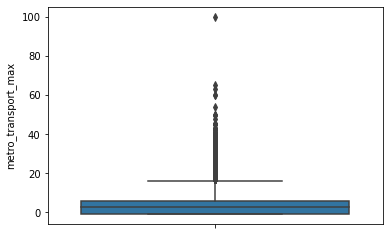

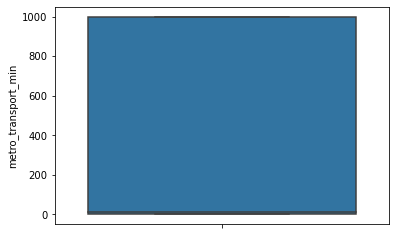

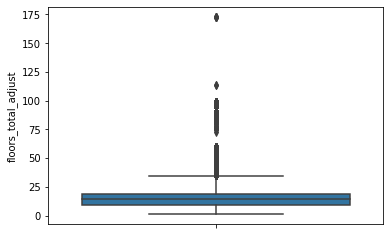

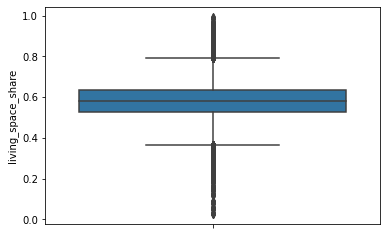

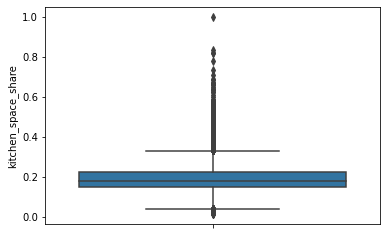

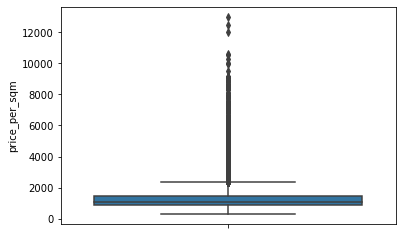

In [38]:
for col in num_cols:
    sns.boxplot(data=df, y=col)
    plt.show()

In [39]:
num_cols

['location_latitude',
 'location_longitude',
 'price_value',
 'area_value',
 'living_space_value',
 'kitchen_space_value',
 'rooms',
 'floor',
 'floors_total',
 'price_agent_fee',
 'studio',
 'metro_1_foot',
 'metro_2_foot',
 'metro_3_foot',
 'metro_1_transport',
 'metro_2_transport',
 'metro_3_transport',
 'metro_foot_max',
 'metro_foot_min',
 'metro_transport_max',
 'metro_transport_min',
 'floors_total_adjust',
 'living_space_share',
 'kitchen_space_share',
 'price_per_sqm']

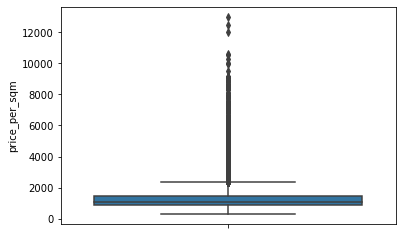

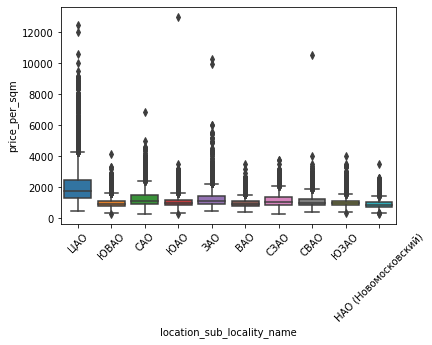

In [40]:
sns.boxplot(data=df, y='price_per_sqm'); plt.show()
sns.boxplot(data=df, y='price_per_sqm', x='location_sub_locality_name')
plt.xticks(rotation=45); plt.show()

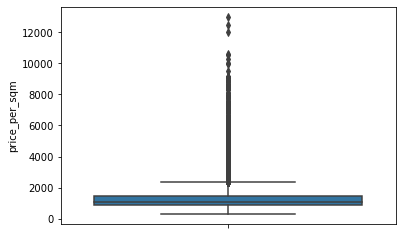

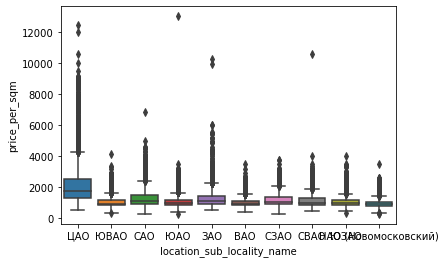

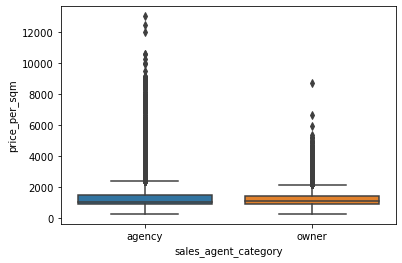

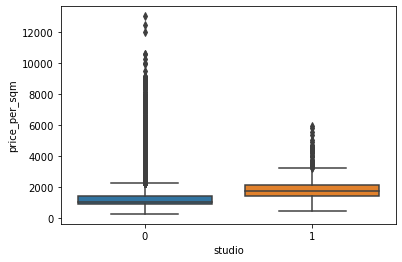

In [41]:
sns.boxplot(data=df, y='price_per_sqm')
plt.show()
for col in cat_cols[:2] + ['studio']:
    sns.boxplot(data=df, y='price_per_sqm', x=col)
    plt.show()

In [42]:
df.sort_values('price_per_sqm', ascending=False).head(int(len(df)*0.01))[['price_per_sqm']+df.columns.tolist()]

,price_per_sqm,location_sub_locality_name,location_latitude,location_longitude,sales_agent_category,price_value,area_value,living_space_value,kitchen_space_value,description,rooms,floor,floors_total,price_agent_fee,studio,metro_1,metro_2,metro_3,metro_1_foot,metro_2_foot,metro_3_foot,metro_1_transport,metro_2_transport,metro_3_transport,metro_foot_max,metro_foot_min,metro_transport_max,metro_transport_min,floors_total_adjust,living_space_share,kitchen_space_share,price_per_sqm
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
272424754,13000.000000,ЮАО,55.675072,37.667815,agency,39000.0,3.0,1.714286,0.567568,"Сдаётся на длительный срок отличная, просторна...",0,4.0,5.0,99,0,Коломенская,Технопарк,Каширская,4.0,-1.0,-1.0,5.0,6.0,-1.0,4.0,4.0,6.0,5.0,5.0,0.571429,0.189189,13000.000000
269946697,12436.245734,ЦАО,55.738171,37.602894,agency,3643820.0,293.0,185.000000,40.000000,Лот 113824. Предлагается в аренду КВАРТИРА на ...,0,1.0,6.0,0,0,Парк Культуры,Кропоткинская,none,10.0,11.0,-1.0,-1.0,-1.0,-1.0,11.0,10.0,-1.0,999.0,6.0,0.631399,0.136519,12436.245734
273005944,12000.000000,ЦАО,55.734420,37.583948,agency,1200000.0,100.0,62.222222,14.925373,Лот 36970. Предлагается в аренду стильная ква...,0,4.0,7.0,0,0,Парк Культуры,Фрунзенская,Смоленская,7.0,18.0,-1.0,4.0,-1.0,-1.0,18.0,7.0,4.0,4.0,8.0,0.622222,0.149254,12000.000000
273230522,10588.651877,ЦАО,55.738171,37.602894,agency,3102475.0,293.0,185.000000,40.000000,Лот 113824. Предлагается в аренду КВАРТИРА на ...,0,1.0,6.0,0,0,Парк Культуры,Кропоткинская,none,10.0,11.0,-1.0,-1.0,-1.0,-1.0,11.0,10.0,-1.0,999.0,6.0,0.631399,0.136519,10588.651877
272782870,10555.555556,СВАО,55.834421,37.659596,agency,570000.0,54.0,31.118644,10.285714,КЛЮЧИ НА РУКАХ! ОФИС В ЖК!Эта просторная двухк...,0,20.0,38.0,0,0,Ростокино,Выставочный центр,ВДНХ,11.0,-1.0,-1.0,4.0,6.0,-1.0,11.0,11.0,6.0,4.0,38.0,0.576271,0.190476,10555.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273138702,4166.666667,ЦАО,55.753169,37.547701,agency,350000.0,84.0,50.000000,15.000000,ВЫГОДНОЕ ВТОРИЧНОЕ ПРЕДЛОЖЕНИЕ. Функциональные...,0,36.0,79.0,10,0,Выставочная,Деловой центр,Тестовская,6.0,11.0,13.0,-1.0,-1.0,-1.0,13.0,6.0,-1.0,999.0,79.0,0.595238,0.178571,4166.666667
270986809,4166.666667,ЦАО,55.749380,37.534092,agency,375000.0,90.0,56.000000,13.432836,Предлагаются в аренду двухкомнатные просторные...,0,19.0,85.0,0,0,Деловой центр,none,none,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,2.0,-1.0,999.0,88.0,0.622222,0.149254,4166.666667
268843348,4166.666667,ЦАО,55.750520,37.539401,agency,250000.0,60.0,37.333333,15.000000,Башня Меркурий. Видовые апартаменты. Полностью...,0,50.0,75.0,0,0,Деловой центр,Выставочная,Международная,2.0,7.0,7.0,-1.0,-1.0,-1.0,7.0,2.0,-1.0,999.0,81.0,0.622222,0.250000,4166.666667


In [43]:
ref = {i: 0 for i in df['location_sub_locality_name'].unique()}
for i in ref.keys():
    ref[i] = df[df['location_sub_locality_name'] == i]['price_per_sqm'].quantile(0.99)

In [44]:
ref_df = pd.DataFrame(
    ref.values(), 
    index=ref.keys(), 
    columns=['cut']
).reset_index(names=['location_sub_locality_name'])

In [45]:
df = df.reset_index().merge(ref_df, on='location_sub_locality_name').set_index('cid')
df = df[df['price_per_sqm'] < df['cut']].drop('cut', axis=1)

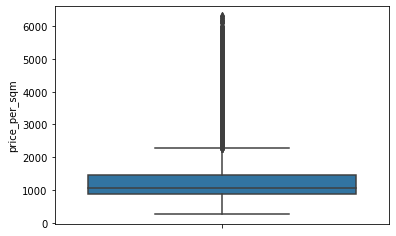

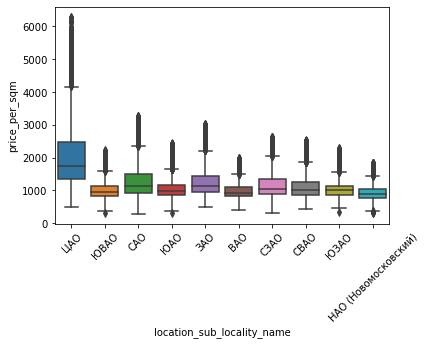

In [46]:
sns.boxplot(data=df, y='price_per_sqm'); plt.show()
sns.boxplot(data=df, y='price_per_sqm', x='location_sub_locality_name')
plt.xticks(rotation=45); plt.show()

In [47]:
df.to_csv('cian_preprocessed_no_extreme.csv')